In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import mpld3
mpld3.enable_notebook()
from scipy.integrate import odeint
import lmfit
from lmfit.lineshapes import gaussian, lorentzian
import warnings
from IPython.core.display import display, HTML, Javascript, clear_output
import sys
import os
import requests
import datetime
from copy import deepcopy

sys.path.append("C:\\Users\\martij\\pythonprogramming\\Utils\\")
sys.path.append('C:\\Users\\martij\\pythonprogramming\\APItokens')
sys.path.append("C:\\Users\\martij\\pythonprogramming\\epydemic")
sys.path.append('C:\\Users\\martij\\Personal\\DataSets\\')
warnings.filterwarnings('ignore')
display(HTML("<style>.container { width:98% !important; }</style>"))

In [45]:
import warnings 
import urllib
import json

####################################################################
def load_dataSet(path, data_type):
    """
    Description:
    
    """
        
    if data_type=='xlsx':
        df_tot = pd.read_excel(path)
        
    elif data_type=='json':
        response = urllib.request.urlopen(path)
        data     = json.loads(response.read())
        df_tot   = pd.DataFrame(data['records'])
        
    elif data_type=='csv':
        df_tot = pd.read_csv(path)        
    
#     beds   = pd.read_csv("https://raw.githubusercontent.com/hf2000510/infectious_disease_modelling/master/data/beds.csv", header=0)
#     df_tot = df_tot.merge(beds.drop('Continent', axis=1).rename(columns={'Country':'countriesAndTerritories'}), on='countriesAndTerritories', how='left')

    df_tot["cases"]       = pd.to_numeric(df_tot["cases"])
    df_tot["day"]         = pd.to_numeric(df_tot["day"])
    df_tot["deaths"]      = pd.to_numeric(df_tot["deaths"])
    df_tot["month"]       = pd.to_numeric(df_tot["month"])
    df_tot["year"]        = pd.to_numeric(df_tot["year"])
    df_tot["popData2019"] = pd.to_numeric(df_tot["popData2019"])
    df_tot['dateRep']     = df_tot.apply(lambda x: datetime.datetime(x['year'], x['month'], x['day']), axis=1)

    return df_tot

####################################################################
def get_country_list_ids(data, by, list_of_ids, verbose=0):
    """
    Description:
    
    Parameters.
    ----------
    
    
    """
    ### Set the correct column name according to the value of 'by' parameter
    if by.lower()=='id':
        col = 'geoId'
    elif by.lower()=='name':
        col = 'countriesAndTerritories'
    else:
        raise Exception('Invalid value for parameter \'by\'. Passed {} but needs to be {\'id\', \'name\'}'.format(by))
    
    country_ids = []
    for identifier in list_of_ids:
        ### extract matching countries by matching identifier to values of the column col of the table
        list_ids   = data[data[col].str.contains(identifier, case=False)]['geoId'].unique()
        list_names = data[data[col].str.contains(identifier, case=False)]['countriesAndTerritories'].unique()
        
        if len(list_ids)==0:
            raise Exception('No country identified by {}. Try a different name or id!'.format(by))
            
        elif len(list_ids)!=1:
            warnings.warn('\nIdentified countries not unique:\n{}.\nTry setting a more specific name or id!'.format(', '.join(list_names)), RuntimeWarning)
            
        if verbose>0:
            print('Unique country identified: {}'.format(list_names[0]))
        
        country_ids.append(list_ids[0])
        
    if verbose>1:
        print('{} countries identified: {}'.format(str(len(country_ids)), ', '.join([data[data['geoId']==cid]['countriesAndTerritories'].values[0] for cid in country_ids])))
    
    return country_ids

####################################################################
def get_data_from_list(data, list_geoids, verbose=0):
    """
    """
    
    if verbose>1:
        print(list_geoids)
        
    return data[data['geoId'].isin(list_geoids)].copy()
    
####################################################################
def get_country_data(data, by, identifier, verbose=0):
    """
    Description:
    
    Parameters:
    ----------
    by: str,
    can be one of ID or NAME. If ID, then the code will try to match
    identifier against the column geoId of the table. If NAME, then 
    the code will try to match the identifier agains the 
    'countriesAndTerritories' column of the table.
    
    identifier: str,
    geoId, or country name, depending on the value set to the "by" 
    parameter.
    
    Returns:
    -------
    
    """
    
    ### Set the correct column name according to the value of 'by' parameter
    if by.lower()=='id':
        col = 'geoId'
    elif by.lower()=='name':
        col = 'countriesAndTerritories'
    else:
        raise Exception('Invalid value for parameter \'by\'. Passed {} but needs to be {\'id\', \'name\'}'.format(by))
        
    ### extract matching countries by matching identifier to values of the column col of the table
    list_ids   = data[data[col].str.contains(identifier, case=False)]['geoId'].unique()
    list_names = data[data[col].str.contains(identifier, case=False)]['countriesAndTerritories'].unique()
    
    if len(list_ids)==0:
        raise Exception('No country identified by {}. Try a different name or id!'.format(by))
        
    elif len(list_ids)!=1:
        warnings.warn('\nIdentified countries not unique:\n{}.\nTry setting a more specific name or id!'.format(', '.join(list_names)), RuntimeWarning)
        
    if verbose>0:
        print('Unique country identified: {}'.format(list_names[0]))
        
    geo_id = list_ids[0]
    
    data_id = data[data['geoId']==geo_id].sort_values('dateRep', ascending=True).copy()
    data_id['totalCases']          = data_id['cases'].cumsum()
    data_id['totalDeaths']         = data_id['deaths'].cumsum()
    data_id['deathsPerMillionHab'] = 1.0e+06*data_id['totalDeaths']/data_id['popData2019']
    return data_id

##################################################
def add_new_data(path_to_new_data, name='Buenos_Aires', geoId='CB', code='CBA', continent='America'):
    """
    Description:
    bla bla
    """
    
    df_new = pd.read_excel(path_to_new_data)

    if 'Muertos' in df_new.columns:
        df_new = df_new[['Fecha', 'Infectados', 'Muertos']].rename(columns={'Fecha':'dateRep', 'Infectados':'cases', 'Muertos': 'deaths'})
    else:
        df_new = df_new[['Fecha', 'Infectados']].rename(columns={'Fecha':'dateRep', 'Infectados':'cases'})
    
    df_new['day'] = df_new['dateRep'].apply(lambda x: x.day)
    df_new['month'] = df_new['dateRep'].apply(lambda x: x.month)
    df_new['year']  = df_new['dateRep'].apply(lambda x: x.year)
    
    if 'deaths' not in df_new.columns:
        df_new['deaths'] = df_new['cases'].apply(lambda x: np.floor(x*0.1))
    
    df_new['countriesAndTerritories'] = df_new['cases'].apply(lambda x: name)
    df_new['geoId'] = df_new['cases'].apply(lambda x: geoId)
    df_new['countryterritoryCode'] = df_new['cases'].apply(lambda x: code)
    df_new['popData2019'] = df_new['cases'].apply(lambda x: 3123466.0)
    df_new['continentExp'] = df_new['cases'].apply(lambda x: continent)
    
    return df_new

In [46]:
# df_ny = pd.read_excel("C:\\LENOVO II\\GUIYE\\BOLUDECES\\COVID 20\\CovidNewYork.xlsx", sep=';')
df_ny = pd.read_csv("C:\\Users\\martij\\Personal\\DataSets\\Covid-19\\new_york_data_1.csv", sep=';| ')
df_ny = df_ny.rename(columns={'DATE_OF_INTEREST': 'dateRep', 'Cases': 'cases', 'Deaths':'deaths'})
df_ny['dateRep'] = pd.to_datetime(df_ny['dateRep'])
df_ny = df_ny.sort_values('dateRep', ascending=False)

# df_ny['totalDeaths'] = df_ny['deaths'].cumsum()
# df_ny['totalCases']  = df_ny['cases'].cumsum()
df_ny['day']   = df_ny['dateRep'].apply(lambda x: x.day)
df_ny['month'] = df_ny['dateRep'].apply(lambda x: x.month)
df_ny['year']  = df_ny['dateRep'].apply(lambda x: x.year)
df_ny['countriesAndTerritories'] = df_ny['cases'].apply(lambda x: 'new_york')
df_ny['geoId']                   = df_ny['cases'].apply(lambda x: 'NY')
df_ny['countryterritoryCode']    = df_ny['cases'].apply(lambda x: 'NYC')
df_ny['popData2019']  = df_ny['cases'].apply(lambda x: 8400000)
df_ny['continentExp'] = df_ny['cases'].apply(lambda x: 'America')
df_ny.head(7)

dateRep  cases  Hospitalizations  deaths  day  month  year  \
236 2020-10-24     17                 0       0   24     10  2020   
235 2020-10-23    162                 2       1   23     10  2020   
234 2020-10-22    418                23       0   22     10  2020   
233 2020-10-21    510                39       2   21     10  2020   
232 2020-10-20    490                53       6   20     10  2020   
231 2020-10-19    538                58       5   19     10  2020   
230 2020-10-18    378                34       4   18     10  2020   

    countriesAndTerritories geoId countryterritoryCode  popData2019  \
236                new_york    NY                  NYC      8400000   
235                new_york    NY                  NYC      8400000   
234                new_york    NY                  NYC      8400000   
233                new_york    NY                  NYC      8400000   
232                new_york    NY                  NYC      8400000   
231                new_york    NY                  NYC      8400000   
230                new_york    NY                  NYC      8400000   

    continentExp  
236      America  
235      America  
234      America  
233      America  
232      America  
231      America  
230      America

In [47]:
# url  = "https://opendata.ecdc.europa.eu/covid19/casedistribution/json/"
#path = "C:\\Users\\martij\\Personal\\DataSets\\Covid-19\\COVID-19-geographic-disbtribution-worldwide-2020-03-28.xlsx"
#path = "C:\\Users\\martij\\Personal\\DataSets\\Covid-19\\COVID-19-geographic-disbtribution-worldwide-2020-10-11.xlsx"
# path = "C:\\Users\\Guillermo\\Python Programs\\Covid-19\\Datos\\COVID-19-geographic-disbtribution-worldwide-2020-06-15.xlsx"
# read the data

path = "C:\\Users\\martij\\Personal\\DataSets\\Covid-19\\COVID-19-geographic-disbtribution-worldwide-2020-10-11.xlsx"
df_tot = load_dataSet(path, 'xlsx').drop('Cumulative_number_for_14_days_of_COVID-19_cases_per_100000', axis=1)
df_tot = pd.concat([df_tot, df_ny])
df_tot.head(7)

Hospitalizations  ICU_Beds  cases continentExp countriesAndTerritories  \
0               NaN       NaN      0         Asia             Afghanistan   
1               NaN       NaN     10         Asia             Afghanistan   
2               NaN       NaN     77         Asia             Afghanistan   
3               NaN       NaN     68         Asia             Afghanistan   
4               NaN       NaN     62         Asia             Afghanistan   
5               NaN       NaN    145         Asia             Afghanistan   
6               NaN       NaN     44         Asia             Afghanistan   

  countryterritoryCode    dateRep  day  deaths geoId  month  popData2019  year  
0                  AFG 2020-10-11   11       0    AF     10   38041757.0  2020  
1                  AFG 2020-10-10   10       1    AF     10   38041757.0  2020  
2                  AFG 2020-10-09    9       2    AF     10   38041757.0  2020  
3                  AFG 2020-10-08    8       1    AF     10   38041757.0  2020  
4                  AFG 2020-10-07    7       2    AF     10   38041757.0  2020  
5                  AFG 2020-10-06    6       5    AF     10   38041757.0  2020  
6                  AFG 2020-10-05    5       0    AF     10   38041757.0  2020

In [108]:
## Load a Base of UCI beds on some country
## Not all countries available
beds        = pd.read_csv("https://raw.githubusercontent.com/hf2000510/infectious_disease_modelling/master/data/beds.csv", header=0)
# beds_lookup = dict(zip(beds["Country"].str.lower(), beds["ICU_Beds"]))
beds_lookup = dict(zip(beds["Country"].apply(lambda x: '_'.join(x.split(' ')).lower()), beds["ICU_Beds"]))

beds_lookup['argentina'] = 25.8
beds_lookup['brazil']    = 6.21
beds_lookup['united_states_of_america'] = beds_lookup['united_states']

print('\n##############################################')
print("# Countries with available values for UCI beds" )
print('##############################################\n')

print(beds_lookup.keys())


##############################################
# Countries with available values for UCI beds
##############################################

dict_keys(['japan', 'south_korea', 'russia', 'germany', 'austria', 'hungary', 'czech_republic', 'poland', 'lithuania', 'france', 'slovakia', 'belgium', 'latvia', 'hong_kong', 'estonia', 'luxembourg', 'switzerland', 'slovenia', 'china', 'greece', 'australia', 'norway', 'portugal', 'netherlands', 'finland', 'italy', 'iceland', 'israel', 'spain', 'ireland', 'turkey', 'united_states', 'new_zealand', 'denmark', 'united_kingdom', 'canada', 'sweden', 'chile', 'colombia', 'india', 'mexico', 'africa', 'europe', 'asia', 'north_america', 'south_america', 'argentina', 'brazil', 'united_states_of_america'])


In [109]:
# gamma = 1.0/9.0
# sigma = 1.0/3.0


def Model(days, gamma, sigma, beds_per_100k, R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D, s, S0, E0, I0, C0, R0, D0):
    
    y0 = S0, E0, I0, C0, R0, D0
    N  = sum(y0)
    
    def deriv(y, t, beta, gamma, sigma, N, p_I_to_C, p_C_to_D, Beds):
        S, E, I, C, R, D = y

        dSdt = -beta(t) * I * S / N
        dEdt = beta(t) * I * S / N - sigma * E
        dIdt = sigma * E - 1/12.0 * p_I_to_C * I - gamma * (1 - p_I_to_C) * I
        dCdt = 1/12.0 * p_I_to_C * I - 1/7.5 * p_C_to_D * min(Beds(t), C) - max(0, C-Beds(t)) - (1 - p_C_to_D) * 1/6.5 * min(Beds(t), C)
        dRdt = gamma * (1 - p_I_to_C) * I + (1 - p_C_to_D) * 1/6.5 * min(Beds(t), C)
        dDdt = 1/7.5 * p_C_to_D * min(Beds(t), C) + max(0, C-Beds(t))
        return dSdt, dEdt, dIdt, dCdt, dRdt, dDdt

    def logistic_R_0(t, R_0_start, k, x0, R_0_end):
        return (R_0_start-R_0_end) / (1 + np.exp(-k*(-t+x0))) + R_0_end

    def beta(t):
        return logistic_R_0(t, R_0_start, k, x0, R_0_end) * gamma

#     N = sum(agegroups)
    
    def Beds(t):
        beds_0 = beds_per_100k / 100_000 * N
        return beds_0 + s*beds_0*t  # 0.003

    t = np.linspace(0, days-1, days)
    ret = odeint(deriv, y0, t, args=(beta, gamma, sigma, N, prob_I_to_C, prob_C_to_D, Beds))
    S, E, I, C, R, D = ret.T

    return t, S, E, I, C, R, D

In [110]:
def SEICRD_fitter(x, gamma, sigma, beds_per_100k, R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D, s, S0, E0, I0, C0, R0, D0):
    days = len(x)
    ret  = Model(days, gamma, sigma, beds_per_100k, R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D, s, S0, E0, I0, C0, R0, D0)
    return ret[6][x]

SEICRD_model = lmfit.Model(SEICRD_fitter)

In [111]:
countryName = 'brazil'
fitDeaths   = 'totalDeaths'
fitCases    = 'totalCases'

In [112]:
## get country data
df   = get_country_data(df_tot, 'name', countryName)

## trim values before first deaths
df   = df[df['totalDeaths']>=1]

## get first death date
fdd  = pd.to_datetime(df.sort_values('totalDeaths', ascending=True)['dateRep'].values[0])

print('\n#########################################################')
print('# The Date for the first Death in {} is: {}'.format(countryName, fdd.strftime('%Y-%m-%d')))
print('#########################################################\n')


#########################################################
# The Date for the first Death in brazil is: 2020-03-18
#########################################################



In [113]:
## Country total Deaths
outbreak_shift = 40

y_data  = df[fitDeaths].values
y_data  = np.concatenate((np.zeros(outbreak_shift), y_data))
x_data  = np.linspace(0, len(y_data)-1, len(y_data), dtype=int)
Npop    = df['popData2019'].values[0]
nbeds   = beds_lookup[countryName]

S0, E0, I0, C0, R0, D0 = Npop-1.0, 1.0, 0.0, 0.0, 0.0, 0.0
INF   = 9.0 # infections lasts four days
INC   = 3.0 # incubation period of five days

## Model Parameters
gamma   = 1.0 / INF
sigma   = 1.0 / INC

phints = {"R_0_start":     {'value': 3.0, 'min': 2.0, 'max': 5.0,   'vary': True},
          "k":             {'value': 2.5, 'min': 0.01, 'max': 5.0,   'vary': True}, 
          "x0":            {'value': 90,  'min': 0.0, 'max': 120,   'vary': True}, 
          "R_0_end":       {'value': 0.9, 'min': 0.3, 'max':3.5,   'vary': True},
          "prob_I_to_C":   {'value': 0.05, 'min': 0.01, 'max': 0.1, 'vary': True}, 
          "prob_C_to_D":   {'value': 0.5, 'min': 0.05, 'max': 0.8, 'vary': True},
          "s":             {'value': 0.01, 'min': 0.0, 'max': 0.1, 'vary': True},
          "beds_per_100k": {'value': nbeds, 'vary': False},
          "gamma":         {'value': gamma,  'vary': False},
          "sigma":         {'value': sigma,  'vary': False},
          "S0":            {'value': S0, 'vary': False},
          "E0":            {'value': E0, 'vary': False},
          "I0":            {'value': I0, 'vary': False},
          "C0":            {'value': C0, 'vary': False},
          "R0":            {'value': R0, 'vary': False},
          "D0":            {'value': D0, 'vary': False}}

for k, vd in phints.items():
    SEICRD_model.set_param_hint(k, **vd)
params     = SEICRD_model.make_params()
fit_method = "least_squares"
params

Parameters([('gamma',
             <Parameter 'gamma', value=0.1111111111111111 (fixed), bounds=[-inf:inf]>),
            ('sigma',
             <Parameter 'sigma', value=0.3333333333333333 (fixed), bounds=[-inf:inf]>),
            ('beds_per_100k',
             <Parameter 'beds_per_100k', value=6.21 (fixed), bounds=[-inf:inf]>),
            ('R_0_start',
             <Parameter 'R_0_start', value=3.0, bounds=[2.0:5.0]>),
            ('k', <Parameter 'k', value=2.5, bounds=[0.01:5.0]>),
            ('x0', <Parameter 'x0', value=90, bounds=[0.0:120]>),
            ('R_0_end', <Parameter 'R_0_end', value=0.9, bounds=[0.3:3.5]>),
            ('prob_I_to_C',
             <Parameter 'prob_I_to_C', value=0.05, bounds=[0.01:0.1]>),
            ('prob_C_to_D',
             <Parameter 'prob_C_to_D', value=0.5, bounds=[0.05:0.8]>),
            ('s', <Parameter 's', value=0.01, bounds=[0.0:0.1]>),
            ('S0',
             <Parameter 'S0', value=211049518.0 (fixed), bounds=[-inf:inf]>),
            ('E0', <Parameter 'E0', value=1.0 (fixed), bounds=[-inf:inf]>),
            ('I0', <Parameter 'I0', value=0.0 (fixed), bounds=[-inf:inf]>),
            ('C0', <Parameter 'C0', value=0.0 (fixed), bounds=[-inf:inf]>),
            ('R0', <Parameter 'R0', value=0.0 (fixed), bounds=[-inf:inf]>),
            ('D0', <Parameter 'D0', value=0.0 (fixed), bounds=[-inf:inf]>)])

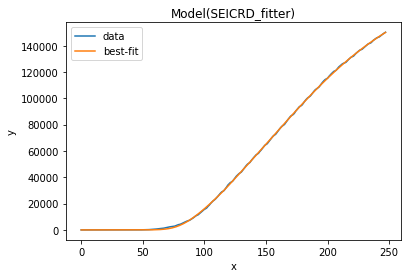

In [114]:
result = SEICRD_model.fit(y_data, params, method=fit_method, x=x_data)
result.plot_fit(datafmt="-")

In [115]:
print(result.fit_report())

[[Model]]
    Model(SEICRD_fitter)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 292
    # data points      = 248
    # variables        = 7
    chi-square         = 44014087.8
    reduced chi-square = 182631.070
    Akaike info crit   = 3011.47471
    Bayesian info crit = 3036.06871
[[Variables]]
    gamma:          0.1111111 (fixed)
    sigma:          0.3333333 (fixed)
    beds_per_100k:  6.21 (fixed)
    R_0_start:      4.99903782 +/- 0.00737742 (0.15%) (init = 3)
    k:              0.16071408 +/- 0.00396891 (2.47%) (init = 2.5)
    x0:             66.2472289 +/- 0.11944863 (0.18%) (init = 90)
    R_0_end:        1.13279718 +/- 0.00216061 (0.19%) (init = 0.9)
    prob_I_to_C:    0.01785487 +/- 0.00110196 (6.17%) (init = 0.05)
    prob_C_to_D:    0.25349439 +/- 0.01333903 (5.26%) (init = 0.5)
    s:              0.00974224 +/- 9.5834e-04 (9.84%) (init = 0.01)
    S0:             2.110495e+08 (fixed)
    E0:             1 (fixed)
    I0:         

In [143]:
## get t_cross date
tcd = pd.to_datetime(fdd+datetime.timedelta(days=result.best_values['x0']-outbreak_shift))

print('\n###################################################')
print('# The SEICRD T_cross date for {} is: {}'.format(countryName, tcd.strftime('%Y-%m-%d')))
print('###################################################\n')

## get R_0 reduction factor
r0rf = result.best_values['R_0_start']/result.best_values['R_0_end']

print('\n#####################################################################')
print('# The R0 Reduction Factor for {} estimated by SEICRD fit is: {:4.2f}'.format(countryName, r0rf))
print('#####################################################################\n')


###################################################
# The SEICRD T_cross date for brazil is: 2020-04-13
###################################################


#####################################################################
# The R0 Reduction Factor for brazil estimated by SEICRD fit is: 4.41
#####################################################################



In [116]:
days  = len(x_data)
model = Model(days, **result.best_values)
y_fit = model[6]
countryName_ = countryName.replace('_', ' ').upper()

fig = plt.figure(figsize=(12, 7))
ax  = fig.add_subplot(111)

ax.plot(x_data, y_data, '-xb', markersize=10, label='{} Data'.format(countryName_))
ax.plot(x_data, y_fit, '-r', linewidth=3, label='SEICRD Fit')
ax.set_title('Cummulative Deaths\n {}'.format(countryName_), fontsize=20)
ax.set_ylabel('Cummulative Deaths', fontsize=16)
ax.set_xlabel('days since outbreak', fontsize=16)
ax.legend()

fig.savefig('./{}_SEICRD_fit.png'.format(countryName)) 

In [136]:
days = len(x_data)
t, S, E, I, C, R, D = Model(days, **result.best_values)
# Model(days, gamma, sigma, beds_per_100k, R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D, s, S0, E0, I0, C0, R0, D0)

In [144]:
fig = plt.figure(figsize=(8, 6))
ax  = fig.add_subplot(111)

y_data_cases  = df[fitCases].values
y_data_cases  = np.concatenate((np.zeros(outbreak_shift), y_data_cases))

ax.plot(t, I.cumsum(), label='SEICRD Fit')
#ax.plot(t, D, label='cumulative deaths'.format(countryName))
ax.plot(t, y_data_cases, 'x-',label='{} Data'.format(countryName_))
ax.set_ylabel('Cumulative Cases',fontsize=18)
ax.set_xlabel('time (days)', fontsize=18)
ax.set_yscale('log')
ax.set_title('{} SEICRD fit'.format(countryName), fontsize=22)
ax.legend()
plt.tight_layout()

In [145]:
from scipy.optimize import curve_fit

def func_exp(x, a, b, c):
    return a * np.exp(b * x) + c

def func_mach(x, t0, Nm, Df):
    return Nm/(1.0+np.exp(-(x-t0)/Df))

In [146]:
yn = I.cumsum()
xp = np.linspace(0, len(yn)-1, len(yn))
popt, pcov = curve_fit(func_mach, xp, yn, p0=[1, 1, 1], maxfev=10000)
perr       = np.sqrt(np.diag(pcov))

print('T0              Nmax             Diff')
print(popt)
print()
print('Error T0      Error Nmax    Error Diff')
print(perr)
print('1/Diff:')
print(1./popt[2])
print(100*perr/popt)

T0              Nmax             Diff
[1.56166592e+02 4.58405248e+08 3.09381100e+01]

Error T0      Error Nmax    Error Diff
[7.24557993e-01 3.47238346e+06 4.75095657e-01]
1/Diff:
0.032322595063181504
[0.46396479 0.75749208 1.53563245]


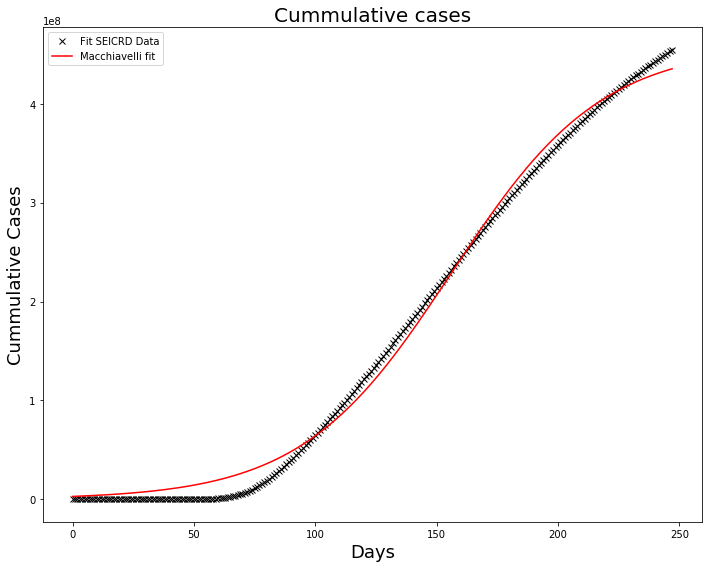

In [147]:
fig = plt.figure(figsize=(10,8))
ax  = fig.add_subplot(111)

ax.plot(xp, yn, 'kx', label="Fit SEICRD Data")
ax.plot(xp, func_mach(xp, *popt), 'r-', label="Fermi Dirac fit")

ax.set_xlabel('Days', fontsize=18)
ax.set_ylabel('Cummulative Cases', fontsize=18)
# ax.set_title('T_0={:4.3f}, Nmax={:4.3f}, 1/Diff={:4.3f}'.format(popt[0], popt[1], 1./popt[2]))
ax.set_title('Cummulative cases', fontsize=20)
#ax.set_yscale('log')
#ax.set_ylim(1,100000)
ax.legend()
plt.tight_layout()

In [121]:
def func_LnNr(x, Nmax):
    ratio = (1.0 - 1.0 * x / Nmax) / (1.0 * x / Nmax)
    
    return np.log(ratio) 

def func_tr(x, t0, diff):
    return (x-t0) * 1.0 / diff

In [134]:
fig = plt.figure(figsize=(8,5))
ax  = fig.add_subplot(111)
# ax.plot(xp, func_mach(xp, *popt))
ax.plot(func_tr(xp, popt[0], popt[2]), func_LnNr(yn, popt[1]),  '^')
ax.set_ylabel('Ln((1-Nr)/Nr)',fontsize=20)
ax.set_xlabel('tr', fontsize=20)
ax.set_title('SEICRD fit',fontsize=24)
fig.savefig('./{}_Ln_fit.png'.format(countryName))

In [124]:
data_df = pd.DataFrame({'day': xp, 'Nt':yn, 'tr':func_tr(xp, popt[0], popt[2]), 'LogNr':  func_LnNr(yn, popt[1])})
data_df.to_csv("C:\\Users\\Guillermo\\Python Programs\\Covid-19\\Datos\\SEICRD_{}_data.csv".format(countryName), index=False, float_format='%16g')